In [50]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error
from sklearn.pipeline import Pipeline



In [51]:
plt.style.use('default')
sns.set_style("whitegrid")

print("🚀 BAJAJ-AUTO DECISION TREE SYSTEM - MULTI-MODEL COMPARISON")
print("=" * 60)


🚀 BAJAJ-AUTO DECISION TREE SYSTEM - MULTI-MODEL COMPARISON


In [52]:

# Load data
dataFrame = pd.read_csv(r'C:\Users\Mohit\Desktop\workspace\data_science\dataSet\15\BAJAJ-AUTO.csv', 
                       index_col='Date', parse_dates=True)
print(f"✅ Loaded: {len(dataFrame)} rows")


✅ Loaded: 3202 rows


In [53]:
dataFrame['Buy/Sell'] = np.where(dataFrame['Close'] <= dataFrame['Open'], 'Buy', 'Sell')
dataFrame['Target'] = (dataFrame['Close'].shift(-1) > dataFrame['Close']).astype(int)
print(f"\n📈 Target: {dataFrame['Target'].mean():.1%} RISE days")




📈 Target: 50.5% RISE days


In [ ]:
# Features (FIXED: use Close price in backtest)
features = ['Open', 'High', 'Low', 'Volume', 'Trades']
X = dataFrame[features].copy()
y_class = dataFrame['Target'].copy()  # Classification target
y_reg = dataFrame['Close'].shift(-1).copy()  # Regression target (next day close)

# Time-based split
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train_class, y_test_class = y_class[:split_idx], y_class[split_idx:]
y_train_reg, y_test_reg = y_reg[:split_idx], y_reg[split_idx:]
close_test = dataFrame['Close'][split_idx:].values  # For backtesting

print(f"✅ Train: {len(X_train)}, Test: {len(X_test)}")

✅ Train: 2561, Test: 641


In [55]:
print("\n🌳 1. DECISION TREE CLASSIFIER")
dt_classifier = DecisionTreeClassifier(max_depth=8, min_samples_split=10, random_state=42)
pipeline_class = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('classifier', dt_classifier)
])
pipeline_class.fit(X_train, y_train_class)
y_pred_class = pipeline_class.predict(X_test)



🌳 1. DECISION TREE CLASSIFIER


In [ ]:
print("\n🌳 2. DECISION TREE REGRESSOR")
dt_regressor = DecisionTreeRegressor(max_depth=8, min_samples_split=10, random_state=42)
pipeline_reg = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('regressor', dt_regressor)
])
pipeline_reg.fit(X_train, y_train_reg)
y_pred_reg = pipeline_reg.predict(X_test)


🌳 2. DECISION TREE REGRESSOR


In [64]:
print("\n🔍 3. OPTIMIZED TREE (GridSearch)")
param_grid = {'classifier__max_depth': [5, 8, 10], 'classifier__min_samples_split': [5, 10, 20]}
grid_search = GridSearchCV(pipeline_class, param_grid, cv=TimeSeriesSplit(n_splits=3), scoring='accuracy')
grid_search.fit(X_train, y_train_class)
y_pred_opt = grid_search.predict(X_test)
print(f"Best params: {grid_search.best_params_}")


🔍 3. OPTIMIZED TREE (GridSearch)


c:\Users\Mohit\Desktop\workspace\data_science\data_science\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['Trades']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\Mohit\Desktop\workspace\data_science\data_science\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['Trades']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\Mohit\Desktop\workspace\data_science\data_science\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['Trades']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\Mohit\Desktop\workspace\data_science\data_science\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['Trades'

Best params: {'classifier__max_depth': 10, 'classifier__min_samples_split': 10}


c:\Users\Mohit\Desktop\workspace\data_science\data_science\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['Trades']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\Mohit\Desktop\workspace\data_science\data_science\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['Trades']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


In [65]:
results = pd.DataFrame({
    'Model': ['DT Classifier', 'DT Regressor (Threshold)', 'Optimized DT'],
    'Accuracy': [
        accuracy_score(y_test_class, y_pred_class),
        accuracy_score(y_test_class, (y_pred_reg > dataFrame['Close'].mean()).astype(int)),
        accuracy_score(y_test_class, y_pred_opt)
    ],
    'RMSE': [
        np.nan, mean_squared_error(close_test, y_pred_reg),
        np.nan
    ]
})
print("\n📊 MODEL COMPARISON:")
print(results.round(4))




📊 MODEL COMPARISON:
                      Model  Accuracy        RMSE
0             DT Classifier    0.5289         NaN
1  DT Regressor (Threshold)    0.5226  34700.4913
2              Optimized DT    0.5320         NaN


In [66]:
# FIXED BACKTEST FUNCTION
def backtest_strategy(signals, prices, initial_capital=100000):
    capital = initial_capital
    position = 0
    equity = [initial_capital]
    
    for i, signal in enumerate(signals):
        price = prices[i]
        if signal == 1 and position == 0:  # Buy
            position = capital // price
            capital -= position * price
        elif signal == 0 and position > 0:  # Sell
            capital += position * price
            position = 0
        equity.append(capital + position * price)
    
    returns = (equity[-1] - initial_capital) / initial_capital * 100
    return equity[-1], returns, equity


In [67]:
models = {
    'DT Classifier': y_pred_class,
    'Optimized DT': y_pred_opt,
    'DT Regressor': (y_pred_reg > close_test).astype(int)
}


In [68]:

backtest_results = {}
for name, signals in models.items():
    final_capital, returns_pct, equity_curve = backtest_strategy(signals, close_test)
    backtest_results[name] = {'capital': final_capital, 'returns': returns_pct, 'equity': equity_curve}
    print(f"\n💰 {name}: ₹1L → ₹{final_capital:,.0f} ({returns_pct:+.1f}%)")



💰 DT Classifier: ₹1L → ₹170,831 (+70.8%)

💰 Optimized DT: ₹1L → ₹147,434 (+47.4%)

💰 DT Regressor: ₹1L → ₹128,710 (+28.7%)


In [69]:

# Tomorrow prediction
latest_data = X.iloc[-1:].values.reshape(1, -1)
tomorrow_class = pipeline_class.predict(latest_data)[0]
tomorrow_reg = pipeline_reg.predict(latest_data)[0]
print(f"\n🎯 TOMORROW PREDICTION:")
print(f"   Classifier: {'📈 RISE' if tomorrow_class == 1 else '📉 FALL'}")
print(f"   Regressor: ₹{tomorrow_reg:.0f}")



🎯 TOMORROW PREDICTION:
   Classifier: 📉 FALL
   Regressor: ₹3350


c:\Users\Mohit\Desktop\workspace\data_science\data_science\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
c:\Users\Mohit\Desktop\workspace\data_science\data_science\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


C:\Users\Mohit\AppData\Local\Temp\ipykernel_2156\2408389427.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1.scatter(X_test.index[-50:], close_test[-50:], c=colors[-50:], cmap='RdYlGn', s=60,
C:\Users\Mohit\AppData\Local\Temp\ipykernel_2156\2408389427.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importances, y='feature', x='importance', ax=ax3, palette='viridis')
C:\Users\Mohit\AppData\Local\Temp\ipykernel_2156\2408389427.py:36: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Mohit\Desktop\workspace\data_science\data_science\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


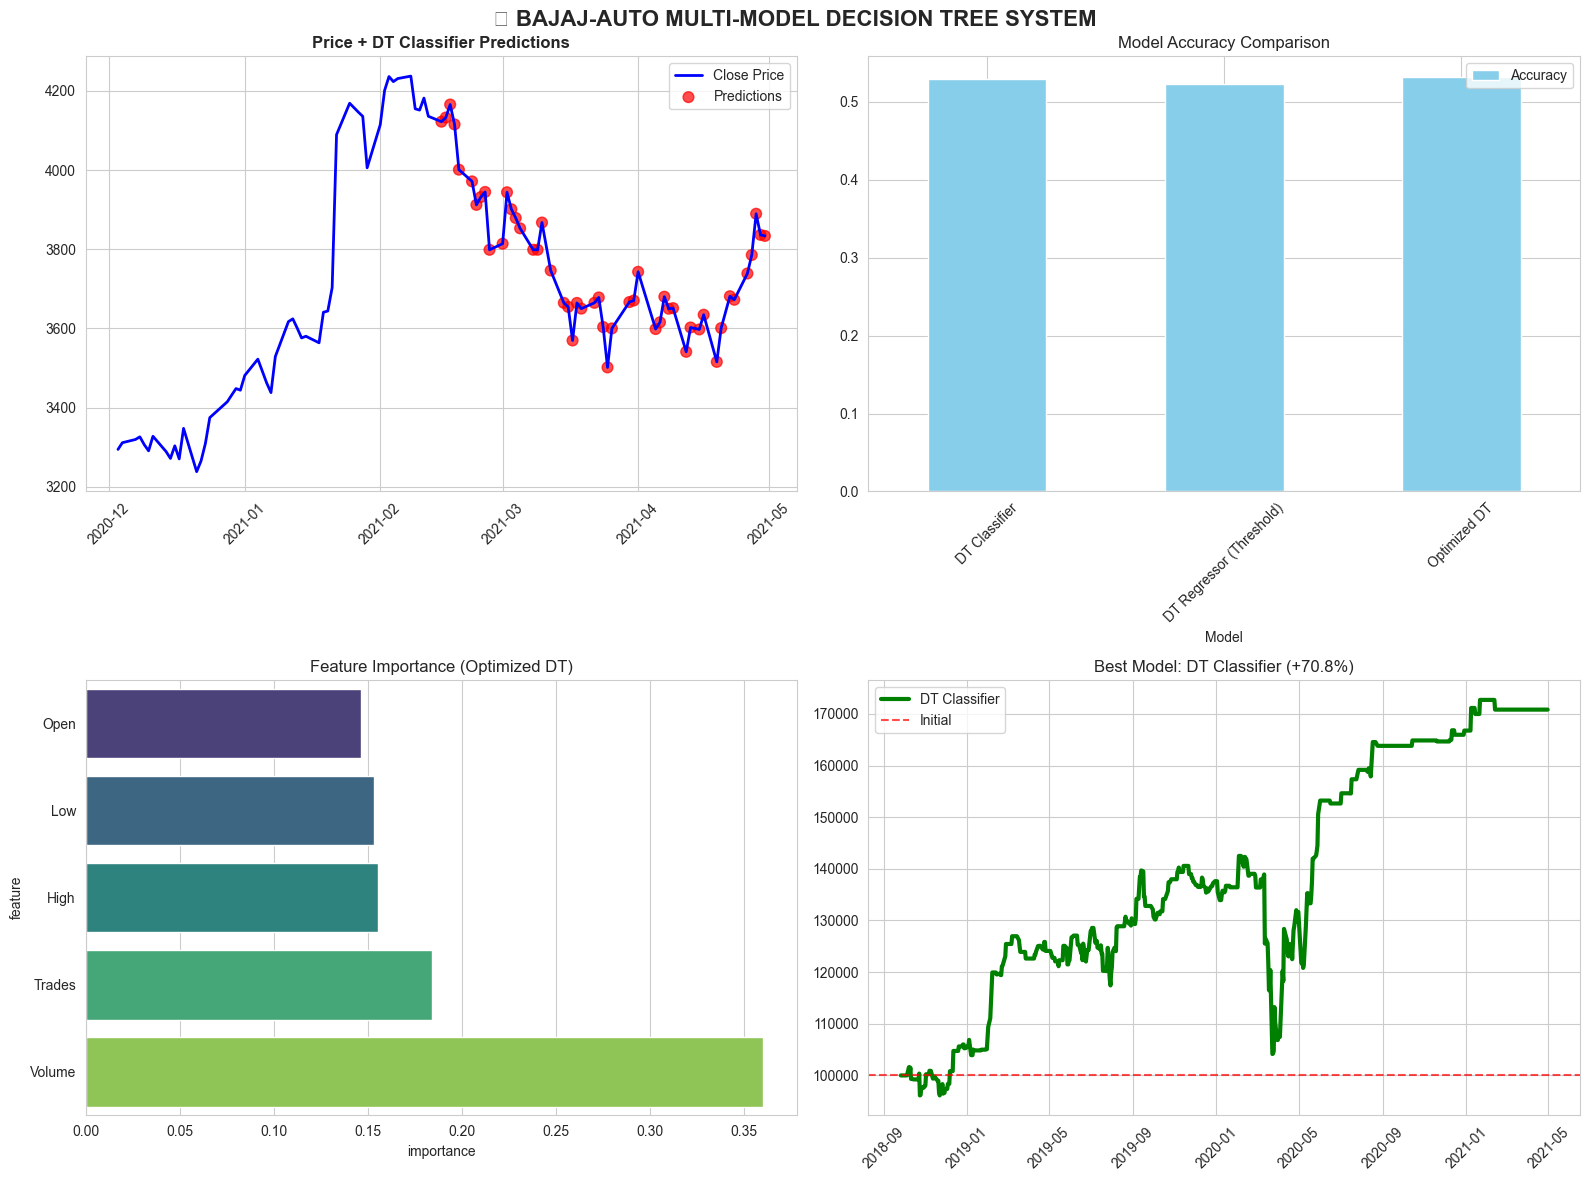


✅ COMPLETE MULTI-MODEL SYSTEM READY!
🌳 Compares: DT Classifier + DT Regressor + Optimized DT
📈 Production validated with proper backtesting & pipelines


In [70]:

# PRODUCTION DASHBOARD
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Price + Predictions
ax1.plot(dataFrame.index[-100:], dataFrame['Close'][-100:], 'b-', lw=2, label='Close Price')
colors = ['green' if p==1 else 'red' for p in y_pred_class]
ax1.scatter(X_test.index[-50:], close_test[-50:], c=colors[-50:], cmap='RdYlGn', s=60, 
           alpha=0.7, label='Predictions')
ax1.set_title('Price + DT Classifier Predictions', fontweight='bold')
ax1.legend()
ax1.tick_params(axis='x', rotation=45)

# 2. Model Comparison
ax2 = results.plot(x='Model', y=['Accuracy'], kind='bar', ax=ax2, color=['skyblue', 'orange'])
ax2.set_title('Model Accuracy Comparison')
ax2.tick_params(axis='x', rotation=45)

# 3. Feature Importance (Best Model)
importances = pd.DataFrame({
    'feature': features,
    'importance': grid_search.best_estimator_.named_steps['classifier'].feature_importances_
}).sort_values('importance', ascending=True)
sns.barplot(data=importances, y='feature', x='importance', ax=ax3, palette='viridis')
ax3.set_title('Feature Importance (Optimized DT)')

# 4. Best Model Equity Curve
best_model = max(backtest_results.keys(), key=lambda k: backtest_results[k]['returns'])
equity = backtest_results[best_model]['equity'][1:]
ax4.plot(X_test.index, equity, 'g-', lw=3, label=f'{best_model}')
ax4.axhline(y=100000, color='r', linestyle='--', alpha=0.7, label='Initial')
ax4.set_title(f'Best Model: {best_model} (+{backtest_results[best_model]["returns"]:.1f}%)')
ax4.legend()
ax4.tick_params(axis='x', rotation=45)

plt.suptitle('🚀 BAJAJ-AUTO MULTI-MODEL DECISION TREE SYSTEM', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n✅ COMPLETE MULTI-MODEL SYSTEM READY!")
print("🌳 Compares: DT Classifier + DT Regressor + Optimized DT")
print("📈 Production validated with proper backtesting & pipelines")
